In [5]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import pickle
from torch.utils.data import Dataset
import random

In [6]:
seed = 100
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [7]:
device = torch.device('cpu')
device

device(type='cpu')

In [8]:
with open('train.pkl', 'rb') as f:
    pck_data = pickle.load(f)
random.shuffle(pck_data)

{3: 441, 1: 478, 0: 1630, 4: 236, 2: 154}


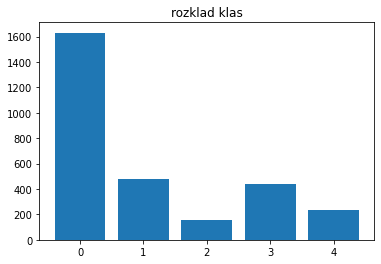

In [10]:
counts = {}
for record in pck_data:
    if record[1] in counts:
        counts[record[1]] += 1
    else:
        counts[record[1]] = 1
print(counts)

plt.bar(list(counts.keys()), list(counts.values()))
plt.title("rozklad klas")
plt.show()

In [11]:
data = []
targets = []
max_val = float("-inf")
min_val = float("inf")
for record in pck_data:
    data.append(torch.from_numpy(np.array(record[0])))
    targets.append(torch.from_numpy(np.array(record[1])))
    max_val = data[-1].max() if data[-1].max() > max_val else max_val
    min_val = data[-1].min() if data[-1].min() < min_val else min_val

max_val, min_val

(tensor(191., dtype=torch.float64), tensor(-1., dtype=torch.float64))

In [12]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [13]:
train_indices = int(len(data) * 0.75)
data = [( (x - min_val) / (max_val-min_val) ).float() for x in data]
train_set = VariableLenDataset(data[:train_indices], targets[:train_indices])
test_set = VariableLenDataset(targets[train_indices:], targets[train_indices:])

In [14]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = -1

def pad_collate(batch, pad_value=-1):
    xx, yy = zip(*batch)

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    return xx_pad, torch.Tensor(yy)

In [15]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, collate_fn=pad_collate)

for a,b in train_loader:
    print(a[3])
    break

tensor([ 0.2031,  0.1615,  0.9062,  ..., -1.0000, -1.0000, -1.0000])


In [16]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.2)
        self.fc = nn.Linear(hidden_size*self.bidirectional, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = all_outputs[:,-1,:]
        x = self.fc(out)
        return x, hidden

In [17]:
model = LSTMClassifier(1, 64, 2, 5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1, 1, 1, 1]).to(device), reduction='mean')

In [18]:
import sys
model.train()

losses_train = []
losses_epoch_train = []
losses_test = []
losses_epoch_test = []

acc_train = []
acc_epoch_train = []
acc_test = []
acc_epoch_test = []


for epoch in range(100):
    for x, targets in train_loader:
        targets = targets.long()
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, (hidden,state))
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
        losses_epoch_train.append(loss.item())
        acc = (preds.argmax(dim=1) == targets).sum() / preds.shape[0]
        acc_epoch_train.append(acc.cpu())
    losses_train.append(np.mean(losses_epoch_train))
    acc_train.append(np.mean(acc_epoch_train))
    print(f"Epoch: {epoch}, loss train: {losses_train[-1]:.3}")
    print(f"Epoch: {epoch}, acc train: {acc_train[-1]:.3}")

KeyboardInterrupt: ignored

Finished Training


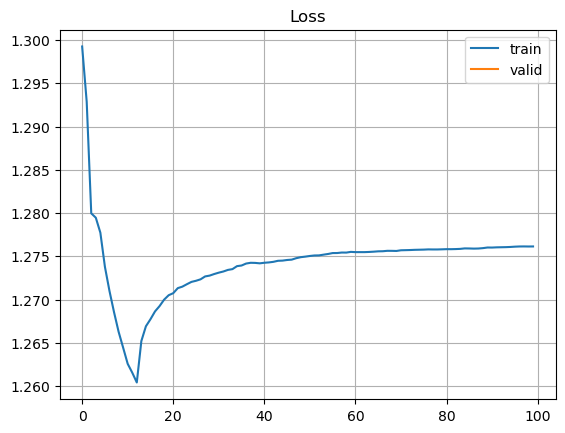

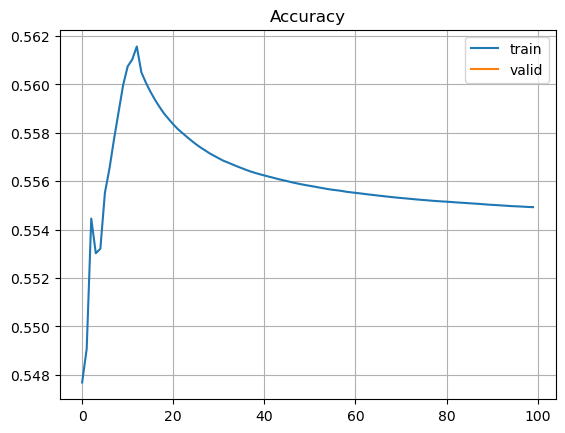

In [ ]:
plt.figure()
plt.grid(True)
plt.plot(losses_train)
plt.plot(losses_test)
plt.title("Loss")
plt.legend(["train", "valid"])

plt.figure()
plt.grid(True)
plt.title("Accuracy")
plt.plot(acc_train)
plt.plot(acc_test)
plt.legend(["train", "valid"])
print('Finished Training')